# Functional Principal Component Analysis (fPCA) Workflow

In [1]:
import os 
import pandas as pd
import numpy as np
from loadData import load_profile, smooth
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from skfda import FDataGrid
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import BSplineBasis
from skfda.exploratory.visualization import FPCAPlot

In [2]:
def load_transcript():
    tss = pd.read_csv(
        'data/ref/GSE49026_S-TSS.txt',
        delimiter='\t',
        usecols=['chr', 'coordinate', 'ORF']
    )
    tss.columns = ['chr', 'start', 'ORF']
    pas = pd.read_csv(
        'data/ref/GSE49026_S-PAS.txt',
        delimiter='\t',
        usecols=['coordinate', 'ORF']
    )
    pas.columns = ['end', 'ORF']
    combined_df = pd.merge(left=tss, right=pas, left_on='ORF', right_on='ORF')
    combined_df['size'] = np.abs(combined_df['start'] - combined_df['end'])
    return combined_df

In [3]:
def load_profile(mat_path_: str):
    nucl_profiles_ = pd.read_csv(
        mat_path_ + '/AlignedProfile.txt',
        delimiter='\s+', 
        header=None,
        index_col=None
    )
    nucl_profiles_['cluster'] = np.loadtxt(mat_path_ + '/cidx.txt', delimiter='\t').astype('int')
    orf_column_ = pd.read_csv(mat_path_ + '/ORF.txt', sep='\t', header=None, names=['ORF'])
    nucl_profiles_['ORF'] = orf_column_
    return nucl_profiles_.sort_values(by='ORF')

## Load data

In [4]:
wt_ocampo_a = load_profile('data/mat/Ocampo_WT_A/')
wt_ocampo_b = load_profile('data/mat/Ocampo_WT_B/')

In [5]:
wt_ocampo_a.drop(['cluster'], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,1192,1193,1194,1195,1196,1197,1198,1199,1200,ORF
57,0.379068,0.379068,0.379068,0.379068,0.388147,0.379068,0.379068,0.372258,0.372258,0.365448,...,1.080456,1.080456,1.082726,1.082726,1.075917,1.057758,1.057758,1.060028,1.060028,YAL001C
56,0.183859,0.179319,0.181589,0.181589,0.177050,0.177050,0.183859,0.188399,0.188399,0.186129,...,0.299622,0.299622,0.299622,0.299622,0.310972,0.310972,0.310972,0.310972,0.315511,YAL002W
55,0.315511,0.315511,0.315511,0.315511,0.320051,0.329131,0.329131,0.333670,0.304162,0.304162,...,0.136192,0.136192,0.136192,0.138462,0.129382,0.122573,0.147541,0.149811,0.147541,YAL003W
54,0.088525,0.088525,0.088525,0.086255,0.090795,0.093065,0.095334,0.093065,0.099874,0.099874,...,0.787644,0.787644,0.789913,0.789913,0.794453,0.796723,0.801263,0.803533,0.810342,YAL005C
53,0.583356,0.572006,0.542498,0.531149,0.524339,0.506180,0.503910,0.503910,0.526609,0.533419,...,0.512990,0.512990,0.449434,0.449434,0.444894,0.447164,0.483482,0.483482,0.483482,YAL007C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4737,0.197834,0.200218,0.188300,0.188300,0.190683,0.190683,0.185916,0.185916,0.185916,0.185916,...,0.850925,0.850925,0.846157,0.817555,0.762734,0.757966,0.755583,0.753199,0.746049,YPR198W
4738,0.030986,0.033370,0.033370,0.033370,0.033370,0.033370,0.033370,0.033370,0.030986,0.030986,...,0.741282,0.746049,0.746049,0.731747,0.629255,0.598269,0.598269,0.631639,0.619721,YPR199C
4739,1.163169,1.163169,1.163169,1.158402,1.160785,1.163169,1.165552,1.172703,1.177470,1.170319,...,0.881911,0.910513,0.912897,0.912897,0.931965,0.929581,0.927198,0.927198,0.929581,YPR200C
4740,0.715063,0.710296,0.710296,0.715063,0.719830,0.715063,0.705529,0.695994,0.703145,0.707912,...,1.515933,1.508782,1.523084,1.506399,1.508782,1.525467,1.527851,1.530234,1.530234,YPR201W


In [6]:
drop_list = ['cluster', 'ORF']
ocampo_a_fd = FDataGrid(
    data_matrix=wt_ocampo_a.drop(drop_list, axis=1).to_numpy(),
    grid_points=np.arange(wt_ocampo_a.drop(drop_list, axis=1).to_numpy().shape[1]),
)

ocampo_b_fd = FDataGrid(
    data_matrix=wt_ocampo_b.drop(drop_list, axis=1).to_numpy(),
    grid_points=np.arange(wt_ocampo_b.drop(drop_list, axis=1).to_numpy().shape[1]),
)

## Apply fPCA

In [7]:
bspline_basis = BSplineBasis(n_basis=20)
bspline_ocampo_a = ocampo_a_fd.to_basis(bspline_basis)
bspline_ocampo_b = ocampo_b_fd.to_basis(bspline_basis)

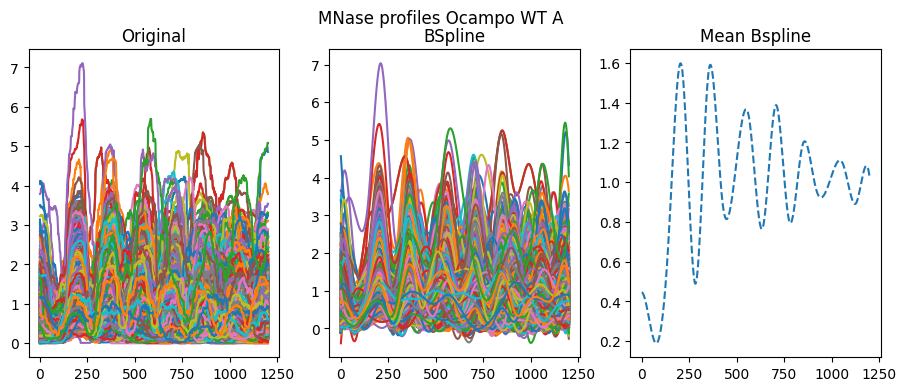

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(11, 4))
ax[0].plot(wt_ocampo_a.drop(drop_list, axis=1).to_numpy().T)
bspline_ocampo_a.plot(chart=ax[1])
bspline_ocampo_a.mean().plot(chart=ax[2], linestyle='--')
fig.suptitle('MNase profiles Ocampo WT A')
ax[0].set_title('Original')
ax[1].set_title('BSpline')
ax[2].set_title('Mean Bspline')
plt.show()

In [9]:
fpca_ocampo_a, fpca_ocampo_b = FPCA(n_components=2), FPCA(n_components=2)
fpc_scores_ocampo_a = fpca_ocampo_a.fit_transform(bspline_ocampo_a)
fpc_scores_ocampo_b = fpca_ocampo_b.fit_transform(bspline_ocampo_b)

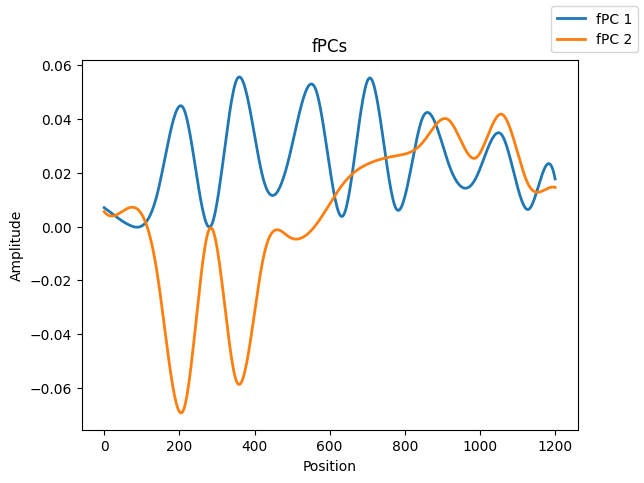

In [10]:
fig = plt.figure()
ax = plt.gca()
fpca_ocampo_a.components_.plot(chart=ax)
ax.get_lines()[0].set_color('tab:blue')
ax.get_lines()[0].set_linewidth(2)
ax.get_lines()[1].set_color('tab:orange')
ax.get_lines()[1].set_linewidth(2)
ax.set_xlabel('Position')
ax.set_ylabel('Amplitude')
ax.set_title('fPCs')
fig.legend(['fPC 1', 'fPC 2'])
plt.show()

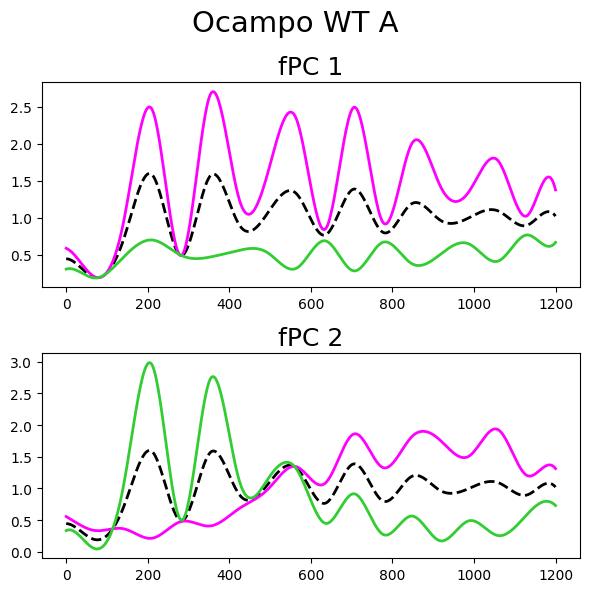

In [11]:
fig = plt.figure(figsize=(6, 2 * 3))
FPCAPlot(
    bspline_ocampo_a.mean(),
    fpca_ocampo_a.components_,
    factor=20,
    fig=fig,
    n_rows=2,
).plot()
ax_list = fig.axes
ax_list[0].set_title('fPC 1', fontsize=18)
ax_list[1].set_title('fPC 2', fontsize=18)
for a in ax_list:
    a.get_lines()[0].set_color('black')
    a.get_lines()[0].set_linestyle('--')
    a.get_lines()[1].set_color('magenta')
    a.get_lines()[2].set_color('limegreen')
    a.get_lines()[0].set_linewidth(2)
    a.get_lines()[1].set_linewidth(2)
    a.get_lines()[2].set_linewidth(2)
    
fig.suptitle('Ocampo WT A', fontsize=21)
fig.tight_layout()

In [12]:
idx = 10

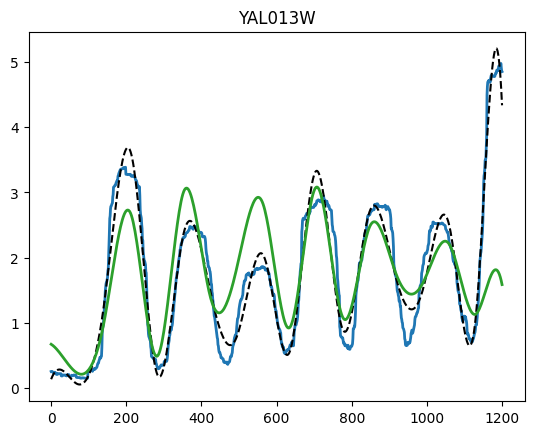

In [13]:
ax = plt.gca()
plt.plot(wt_ocampo_a.iloc[idx].drop(drop_list), lw=2)
bspline_ocampo_a[idx].plot(chart=ax, linestyle='--', color='black')
(bspline_ocampo_a.mean()
 + fpca_ocampo_a.components_[0] * fpc_scores_ocampo_a[idx][0] 
 + fpca_ocampo_a.components_[1] * fpc_scores_ocampo_a[idx][1]
).plot(chart=ax, color='tab:green', lw=2)
plt.title(wt_ocampo_a.iloc[idx]['ORF'])
plt.show()

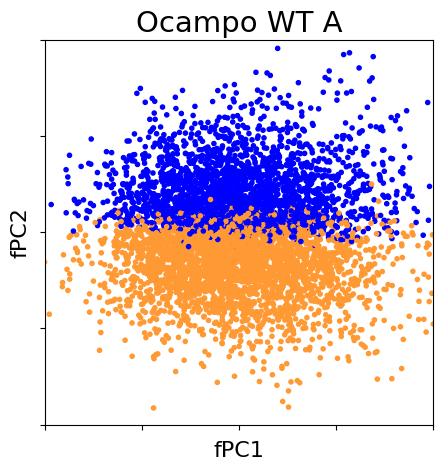

In [14]:
colors = np.array([[0., 0., 1., 1., ], [1., .6, .2, 1., ]])
plt.figure(figsize=(5, 5))
ax_score = plt.gca()
ax_score.scatter(*fpc_scores_ocampo_a.T, color=colors[wt_ocampo_a['cluster'] - 1], marker='.')

ax_score.set_ylim((-20, 20))
ax_score.set_xlim((-20, 20))
plt.xlabel('fPC1', fontsize=16)
plt.ylabel('fPC2', fontsize=16)
plt.xticks(np.arange(-20, 21, 10), [])
plt.yticks(np.arange(-20, 21, 10), [])
plt.title('Ocampo WT A', fontsize=21)
plt.show()

In [16]:
fpca_ocampo_a_3d = FPCA(n_components=3)
fpc_scores_ocampo_a_3d = fpca_ocampo_a_3d.fit_transform(bspline_ocampo_a)

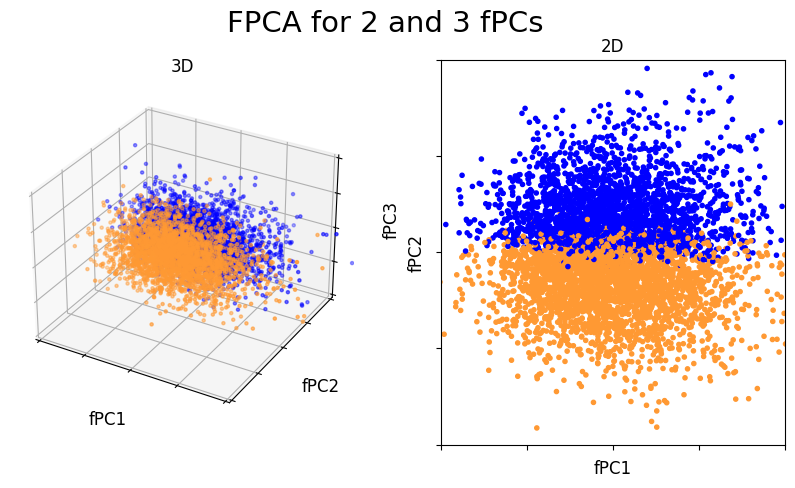

In [31]:
fig = plt.figure(figsize=(10, 5))
(ax_2d, ax_3d) = fig.add_subplot(122), fig.add_subplot(121, projection='3d')
ax_2d.scatter(*fpc_scores_ocampo_a.T, color=colors[wt_ocampo_a['cluster'] - 1], marker='.')
ax_3d.scatter(*fpc_scores_ocampo_a_3d.T, color=colors[wt_ocampo_a['cluster'] - 1], marker='.')
ax_2d.set_title('2D')
ax_3d.set_title('3D')
for a in [ax_2d, ax_3d]:
    a.set_ylim((-20, 20))
    a.set_xlim((-20, 20))
    a.set_xlabel('fPC1', fontsize=12)
    a.set_ylabel('fPC2', fontsize=12)
    a.set_xticks(np.arange(-20, 21, 10))
    a.set_xticklabels([])
    a.set_yticks(np.arange(-20, 21, 10))
    a.set_yticklabels([])
    
ax_3d.set_zlim((-20, 20))
ax_3d.set_zlabel('fPC3', fontsize=12, rotation=90)
ax_3d.set_zticks(np.arange(-20, 21, 10))
ax_3d.set_zticklabels([])
fig.suptitle('FPCA for 2 and 3 fPCs', fontsize=21)
plt.subplots_adjust(wspace=0.25)
plt.show()